In [ ]:
!pip install skorch

In [1]:
import os

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from tqdm import tqdm

In [ ]:
!nvidia-smi

In [ ]:
segmentation_classifier = keras.models.load_model('models/MIMIC-256x25680-20-split-resnet-Float16_2-race_detection_rop_seg_data_rop_seg-0.001_20220321-054140_epoch:011.hdf5')
segmentation_classifier.summary()

In [2]:
# code in one place, running in another directory
# code is to be run in below directory

os.chdir("/users/riya/race/classifier_experiments/CNN_train")

In [3]:
!ls

dataset  outputs


### Prepare Dataset

We'll try a 70/10/20 split (train/val/test). We don't have access to info outside of black/white, so we'll just do a simple split.

In [ ]:
race_data = pd.read_csv("/users/riya/race/csv/image_race_data.csv")

In [ ]:
pd.value_counts(race_data['race'])

In [ ]:
1709 / (1709 + 2837)

In [ ]:
def prepare_dataset():
    
    csv_path = "/users/riya/race/csv/image_race_data.csv"
    data_path = "/users/riya/race/dataset/segmentations/"
    save_path = "/users/riya/race/classifier_experiments/CNN_train/dataset/"
    
    race_data = pd.read_csv(csv_path)
    race_data['stratify'] = race_data['race'] + '_' + race_data['variable'] 
    # new column so I can account for both variable and race in my stratification
    
    ratio_train = 0.7
    ratio_val = 0.1
    ratio_test = 0.2
    
    # split into 80% train and val, 20% test
    
    X_intermediate, X_test, y_intermediate, y_test = train_test_split(race_data, race_data['race'], test_size=ratio_test, 
                                                        stratify = race_data['stratify'], random_state=86)
    
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining
    
    # split into 70% train and 10% val
    
    X_train, X_val, y_train, y_val = train_test_split(X_intermediate, X_intermediate['race'], test_size=ratio_val_adjusted, 
                                                        stratify = X_intermediate['stratify'], random_state=86)

    
    def populate_folders(data_df, data_type):
    
        for i in tqdm(range(len(data_df))):
            data_df.reset_index(drop=True, inplace=True)
            img_id = data_df['image_id'][i]
            race = data_df['race'][i]

            img = np.array(Image.open(data_path + str(img_id) + '.bmp'))
            img = Image.fromarray(img)

            img.save(save_path + str(data_type) + '/' + str(race) + '/' + str(img_id) + '.bmp')
    
    populate_folders(X_train, 'train')
    populate_folders(X_val, 'val')
    populate_folders(X_test, 'test')


In [ ]:
prepare_dataset()

### Model Definitions

In [4]:
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model

    def forward(self, x):
        return self.model(x)

### Preprocessing

In [5]:
# Already done this, before I saved my images
# Yay, we did the same thing, repeating the image thrice to create the three layers. I can just do that part.

# Oh, I see. Rather than saving ALL the images (as I wrongly did), it's so much easier to just make them in the train code!

# depending on the inputs, I can run this code 8 times to train this model. It'll be easy to train at that point!

def shadow_regions(img, skeleton, shadow, radius, region, image_size = (224, 224)):
    
    img = np.array(img)
    img = cv2.resize(img, image_size)
    
    # defining channel which will be duplicated late (in case it's not already with Image Folder??)
    channel = img[:,:,0]

    if skeleton is True:
        # can binarize all 3 channels, but will go 1 at a time
        channel[channel > 0] = 255       
        modified_img = skeletonize(channel, method='lee')
    
    if shadow is True:
        # developing mask that darkens center portion
        center_mask = np.full(image_size, 255, dtype=np.uint8) 
        # radius i changes, center, color, fill is the same
        cv2.circle(center_mask, (int(image_size[0]/2), int(image_size[0]/2)), radius, (0, 0, 0), -1)

        # developing mask that darkens background region
        back_mask = cv2.bitwise_not(center_mask)

        if (region == 'dark_center'):
            modified_img = cv2.bitwise_or(channel, channel, mask=center_mask)

        if (region == 'dark_background'):
            modified_img = cv2.bitwise_or(channel, channel, mask=back_mask)
        
    img[:,:,0] = modified_img
    img[:,:,1] = modified_img
    img[:,:,2] = modified_img
    print (img.shape)

    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((image_size[0],image_size[1],3)) # (1, 224, 224, 3)?
    img = Image.fromarray(img)

    return img

Options for different saving:
1. Skeleton = True,
    Shadow = True then
    Region has two options 
    Radius has two options
2. Original Training: shadow = False & Skeleton = False
3. no skeletonization training: Skeleton = false & Shadow = true

In [ ]:
img_arr = np.array(Image.open("/users/riya/race/dataset/segmentations/" + str(7571) + '.bmp'))
img = Image.fromarray(img_arr)

In [ ]:
plt.imshow(img, interpolation = 'nearest', cmap = 'gray')
plt.show()

In [ ]:
img_arr.shape

In [ ]:
image_size = (224, 224)

In [ ]:
img = cv2.resize(img_arr, image_size)

In [ ]:
img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((image_size[0],image_size[1],3)) # (1, 224, 224, 3)?

### Train Code

In [6]:
def train(data_dir, radius, region, skeleton=False, shadow = False, num_classes=2, batch_size=64, num_epochs=10, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    if device == 'cuda': # using all available gpus
        torch.cuda.empty_cache()
    if skeleton is True: # Experiment #2: skeleton true, shadow true
        shadow = True
        f_params = f'./outputs/checkpoints/model_shadow_regions_{region}_{radius}_skeletonized.pt'
        f_history = f'./outputs/histories/model_shadow_regions_{region}_{radius}_skeletonized.json'
        csv_name = f'./outputs/probabilities/shadow_regions_{region}_{radius}_skeletonized.csv'
    elif shadow is True: # Experiment #3: skeleton false, shadow true
        f_params = f'./outputs/checkpoints/model_shadow_regions_{region}_{radius}.pt'
        f_history = f'./outputs/histories/model_shadow_regions_{region}_{radius}.json'
        csv_name = f'./outputs/probabilities/shadow_regions_{region}_{radius}.csv'
    else: # Original training: skeleton false, shadow false
        f_params = f'./outputs/checkpoints/model_original.pt'
        f_history = f'./outputs/histories/model_original.json'
        csv_name = f'./outputs/probabilities/original.csv'
        
    train_transforms = transforms.Compose([transforms.Lambda(lambda img: shadow_regions(img, skeleton,
                                                                                shadow, radius,
                                                                                region)), # image size pre-defined
                                           # transforms.Resize(image_size),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.RandomVerticalFlip(),
                                           transforms.RandomRotation(25),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.5, 0.5, 0.5],
                                                                [0.5, 0.5, 0.5])]) # why this normalizing?

    test_transforms = transforms.Compose([transforms.Lambda(lambda img: shadow_regions(img, skeleton,
                                                                                shadow, radius,
                                                                                region)),
                                          # transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5],
                                                               [0.5, 0.5, 0.5])])

    train_folder = os.path.join(data_dir, 'train') # only training on segmentations      
    val_folder = os.path.join(data_dir, 'val')
    test_folder = os.path.join(data_dir, 'test')

    # I guess this automatically creates 3 channels
    train_dataset = datasets.ImageFolder(train_folder, train_transforms)
    val_dataset = datasets.ImageFolder(val_folder, test_transforms)
    test_dataset = datasets.ImageFolder(test_folder, test_transforms)

    
    labels = np.array(train_dataset.samples)[:,1]
    
    # what even does the below code do?    
    labels = labels.astype(int)
    black_weight = 1 / len(labels[labels == 0])
    white_weight = 1 / len(labels[labels == 1])
    sample_weights = np.array([black_weight, white_weight])
    weights = sample_weights[labels]
    sampler = torch.utils.data.WeightedRandomSampler(weights, len(train_dataset), replacement=True)

    print()
    print(f'Data Directory: {data_dir}')
    print(f'Skeletonize: {skeleton}')
    print(f'Shadow: {shadow}')
    print(f'Number of Classes: {num_classes}')
    print(f'Number of black eyes: {len(labels[labels == 0])}')
    print(f'Number of white eyes: {len(labels[labels == 1])}')
    print(f'Batch Size: {batch_size}')
    print(f'Number of Epochs: {num_epochs}')
    print(f'Initial Learning Rate: {lr}')
    print(f'Device: {device}')
    print()

    # maybe increase size of validation set??
    
    checkpoint = Checkpoint(monitor='valid_loss_best',
                            f_params=f_params,
                            f_history=f_history,
                            f_optimizer=None,
                            f_criterion=None)

    # accuracy on train/validation?
    
    train_acc = EpochScoring(scoring='accuracy',
                             on_train=True,
                             name='train_acc',
                             lower_is_better=False)

    early_stopping = EarlyStopping()

    callbacks = [checkpoint, train_acc, early_stopping]

    net = NeuralNetClassifier(PretrainedModel,
                              criterion=nn.CrossEntropyLoss,
                              lr=lr,
                              batch_size=batch_size,
                              max_epochs=num_epochs,
                              module__output_features=num_classes,
                              optimizer=optim.SGD,
                              optimizer__momentum=0.9,
                              iterator_train__num_workers=16,
                              iterator_train__sampler=sampler,
                              iterator_valid__shuffle=False,
                              iterator_valid__num_workers=16,
                              train_split=predefined_split(val_dataset),
                              callbacks=callbacks,
                              device=device)

    net.fit(train_dataset, y=None)

    img_locs = [loc for loc, _ in test_dataset.samples]
    test_probs = net.predict_proba(test_dataset)
    test_probs = [prob[0] for prob in test_probs]
    data = {'img_loc' : img_locs, 'probability' : test_probs}
    pd.DataFrame(data=data).to_csv(csv_name, index=False)


Data Directory: dataset
Skeletonize: False
Shadow: False
Number of Classes: 2
Number of black eyes: 1197
Number of white eyes: 1984
Batch Size: 64
Number of Epochs: 10
Initial Learning Rate: 0.001
Device: cuda

channel 2
channel 2channel 2

channel 2channel 2channel 2channel 2channel 2


channel 2


channel 2channel 2channel 2channel 2channel 2




channel 2channel 2



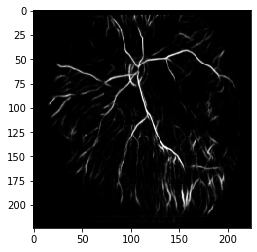

(224, 224, 3)


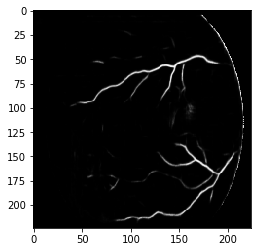

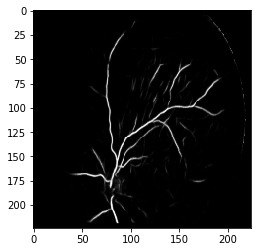

(224, 224, 3)(224, 224, 3)



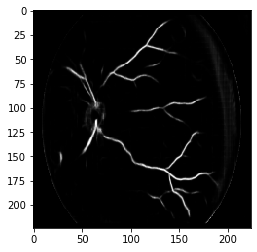

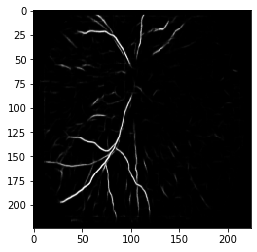

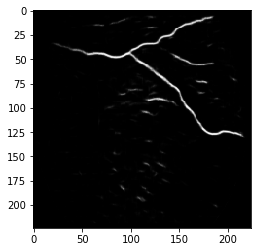

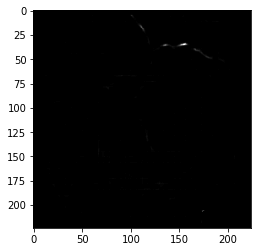

(224, 224, 3)

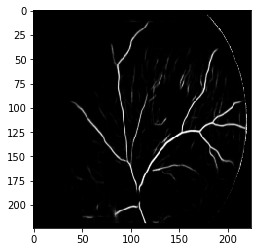

(224, 224, 3)
(224, 224, 3)

channel 2channel 2(224, 224, 3)(224, 224, 3)


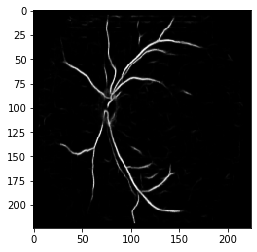

channel 2





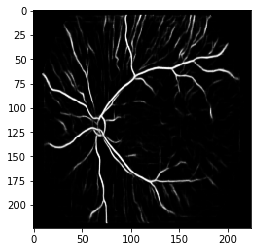

channel 2(224, 224, 3)channel 2channel 2

(224, 224, 3)

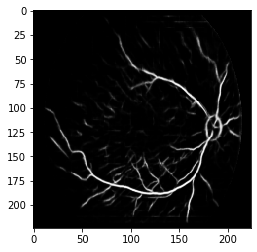




channel 2
(224, 224, 3)
channel 2

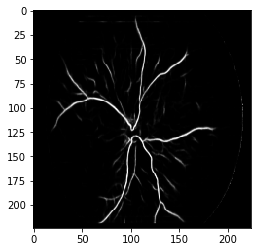


channel 2
(224, 224, 3)
channel 2channel 2

channel 2


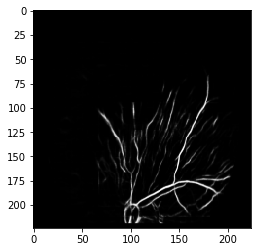

(224, 224, 3)
channel 2


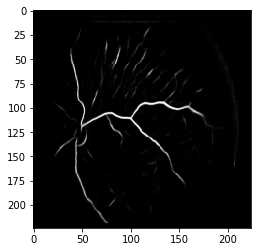

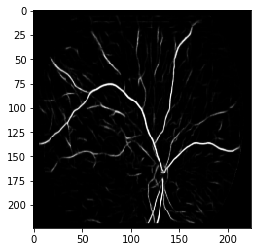

(224, 224, 3)
(224, 224, 3)
channel 2
channel 2


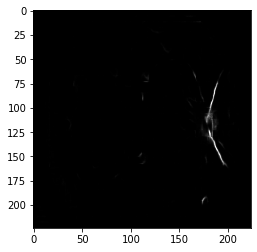

(224, 224, 3)
channel 2


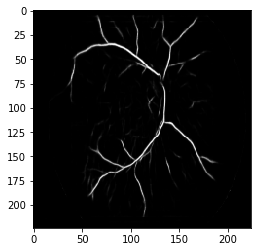

(224, 224, 3)


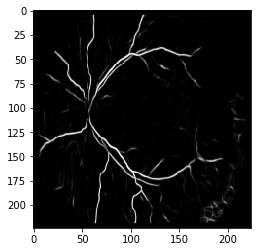

(224, 224, 3)


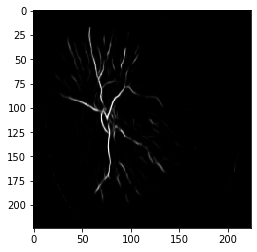

(224, 224, 3)


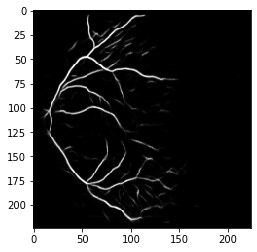

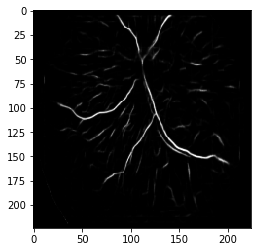

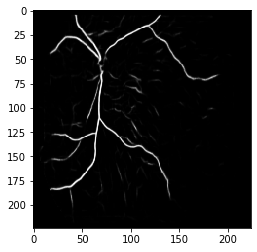

(224, 224, 3)

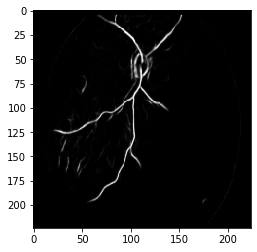

(224, 224, 3)
(224, 224, 3)

(224, 224, 3)


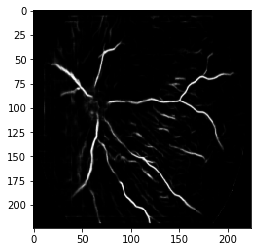

(224, 224, 3)


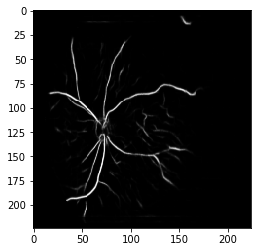

(224, 224, 3)


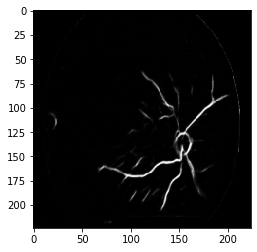

(224, 224, 3)


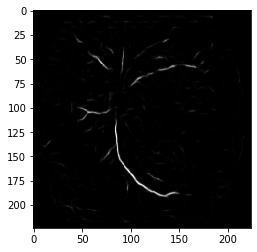

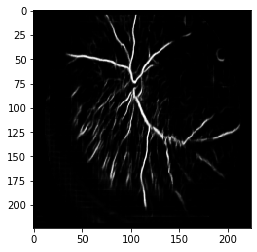

(224, 224, 3)
(224, 224, 3)


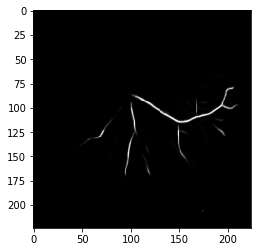

(224, 224, 3)


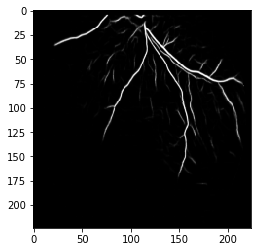

(224, 224, 3)


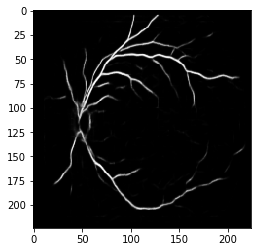

channel 2
(224, 224, 3)


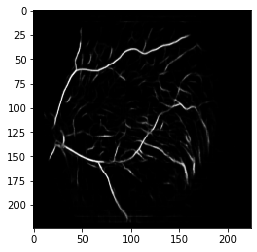

(224, 224, 3)


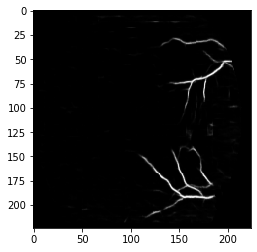

(224, 224, 3)


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.6/dist-packages/torchvision/datasets/folder.py", line 234, in __getitem__
    sample = self.transform(sample)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py", line 61, in __call__
    img = t(img)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py", line 437, in __call__
    return self.lambd(img)
  File "<ipython-input-6-cdef1ff7c5ef>", line 21, in <lambda>
    region)), # image size pre-defined
  File "<ipython-input-5-f462f65396f8>", line 40, in shadow_regions
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((image_size[0],image_size[1],3)) # (1, 224, 224, 3)?
ValueError: cannot reshape array of size 451584 into shape (224,224,3)


In [7]:
if __name__ == '__main__':
    if not os.path.isdir(os.path.join('outputs', 'probabilities')):
        os.makedirs(os.path.join('outputs', 'probabilities'))
    if not os.path.isdir(os.path.join('outputs', 'checkpoints')):
        os.makedirs(os.path.join('outputs', 'checkpoints'))
    if not os.path.isdir(os.path.join('outputs', 'histories')):
        os.makedirs(os.path.join('outputs', 'histories'))

    data_dir = os.path.join('dataset')

    train(data_dir, 0, 0)